![Open Screen](https://github.com/Slenderman00/open_screen/blob/master/media/banner.png?raw=true)

### Downloads the dataset

Remember to install kaggle and set the kaggle api key `pip install kaggle`

In [9]:
import os
import subprocess
from IPython.display import clear_output
from shutil import rmtree


cwd = os.getcwd()
main_dataset_path = f'{cwd}/dataset'
if not os.path.exists(main_dataset_path):
    process = subprocess.Popen('bash download_dataset.sh', shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, universal_newlines=True)
    for stdout_line in iter(process.stdout.readline, ""):
        clear_output(wait=True)
        print(stdout_line, end="")
    process.stdout.close()
    process.wait()
    assert process.returncode == 0
    print('Finished downloading and extracting')

    dataset_len = len(os.listdir(f'{cwd}/dataset/image')) # Remember to do - 1 to get the actual index
    dataset_path = f'{cwd}/supervisely_person_clean_2667_img/supervisely_person_clean_2667_img'

    # append data from supervisely_person_clean_2667_img to dataset
    for idx, file in enumerate(os.listdir(f'{dataset_path}/images')):
        file_png = file.split('.')[0] + '.png'

        os.rename(f'{dataset_path}/masks/{file_png}', f'{main_dataset_path}/mask/{idx + dataset_len - 1}.png')
        os.rename(f'{dataset_path}/images/{file}', f'{main_dataset_path}/image/{idx + dataset_len - 1}.jpg')

    rmtree(f'{cwd}/supervisely_person_clean_2667_img')

    dataset_path = f'{cwd}/segmentation_full_body_tik_tok_2615_img/segmentation_full_body_tik_tok_2615_img'

    # append data from segmentation_full_body_tik_tok_2615_img to dataset
    for idx, file in enumerate(os.listdir(f'{dataset_path}/images')):
        file_png = file.split('.')[0] + '.png'
    
        os.rename(f'{dataset_path}/masks/{file_png}', f'{main_dataset_path}/mask/{idx + dataset_len - 1}.png')
        os.rename(f'{dataset_path}/images/{file}', f'{main_dataset_path}/image/{idx + dataset_len - 1}.jpg')
    
    rmtree(f'{cwd}/segmentation_full_body_tik_tok_2615_img')

### Calculate mean and std

In [10]:
import os
from PIL import Image
import torch
from torchvision import transforms

cwd = os.getcwd()

sums = torch.zeros(3)
squared_sums = torch.zeros(3)
count = 0

for image in os.listdir(f'{cwd}/dataset/image'):
    image = f'{cwd}/dataset/image/{image}'
    image = Image.open(image).convert('RGB')

    image_tensor = transforms.ToTensor()(image)

    sums += image_tensor.sum(dim=[1, 2])
    squared_sums += (image_tensor ** 2).sum(dim=[1, 2])
    count += image_tensor.size(1) * image_tensor.size(2)

    del image
    del image_tensor

mean = sums / count
std = (squared_sums / count - mean ** 2) ** 0.5

print(f'Mean: {mean}')
print(f'Std: {std}')

Mean: tensor([0.4117, 0.5926, 0.3815])
Std: tensor([0.3299, 0.3250, 0.3212])


### Create a custom dataset loader for pytorch

In [11]:
import os
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
from random import random
import numpy as np

class ReplaceColor(object):
    def __init__(self, target_color, threshold=0, replacement_color=None):
        """
        Args:
            target_color (tuple): The RGB color to replace (e.g., (255, 255, 255) for white).
            threshold (int): Maximum distance from target_color to still be replaced.
            replacement_color (tuple, optional): The RGB color to use as a replacement.
                If None, a random color will be generated each time.
        """
        self.target_color = np.array(target_color, dtype=np.uint8)
        self.threshold = threshold
        if replacement_color is not None:
            self.replacement_color = np.array(replacement_color, dtype=np.uint8)
        else:
            self.replacement_color = None

    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to be transformed.

        Returns:
            PIL Image: Image with target color replaced.
        """
        np_img = np.array(img)
        # Calculate the distance from each pixel to the target color
        dist = np.linalg.norm(np_img - self.target_color, axis=-1)
        # Create a mask where the distance is less than or equal to the threshold
        mask = dist <= self.threshold
        if self.replacement_color is None:
            # Generate a random color
            random_color = np.random.randint(0, 256, 3, dtype=np.uint8)
        else:
            random_color = self.replacement_color

        np_img[mask] = random_color
        return Image.fromarray(np_img)

    def __repr__(self):
        return self.__class__.__name__ + '(target_color={0}, threshold={1}, replacement_color={2})'.format(self.target_color, self.threshold, self.replacement_color)

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        if random() < .5:
            return tensor + torch.randn(tensor.size()) * self.std + self.mean
        return tensor
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

image_transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize the images to a fixed size
    #ReplaceColor(target_color=(0, 255, 0), threshold=10),
    transforms.ToTensor(),  # Convert the images to tensors
    transforms.Normalize(mean, std), # Normalise data
    #AddGaussianNoise(0., 1.)
])

mask_transform = transforms.Compose([
    transforms.Resize((512, 512)),   # Resize the masks to a fixed size
    transforms.Grayscale(),          # Convert masks to grayscale if they are not already
    transforms.ToTensor(),        # Convert the masks to tensors
])

class CustomLoader(Dataset):
    def __init__(self, device='cpu'):
        self.device = device
        self.cwd = os.getcwd()
        self.len = len(os.listdir(f'{self.cwd}/dataset/image'))

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        image_path = f'{self.cwd}/dataset/image/{idx}.jpg'
        mask_path = f'{self.cwd}/dataset/mask/{idx}.png'

        image = Image.open(image_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')  # Convert mask to grayscale

        # Apply the transformations
        image_tensor = image_transform(image).float()
        mask_tensor = mask_transform(mask).float()

        # If mask is not single-channel, take the first channel
        if mask_tensor.size(0) != 1:
            mask_tensor = mask_tensor[0].unsqueeze(0)

        # Move tensors to the specified device
        image_tensor = image_tensor.to(self.device)
        mask_tensor = mask_tensor.to(self.device)

        return {'images': image_tensor, 'masks': mask_tensor}

### U-Net 
After the disappointing performance of the last model we have decided to implement a variant of the U-Net architecture

![u-net](https://upload.wikimedia.org/wikipedia/commons/2/2b/Example_architecture_of_U-Net_for_producing_k_256-by-256_image_masks_for_a_256-by-256_RGB_image.png)

(https://en.wikipedia.org/wiki/U-Net)

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleUnet(nn.Module):
    def __init__(self):
        super(SimpleUnet, self).__init__()

        # Down conv
        self.down_conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(2, 2)
        self.down_conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(2, 2)
        self.down_conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.pool3 = nn.MaxPool2d(2, 2)
        self.down_conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        # Up conv
        self.up_conv1 = nn.Sequential(
            nn.Conv2d(512 + 256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.up_conv2 = nn.Sequential(
            nn.Conv2d(256 + 128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.up_conv3 = nn.Sequential(
            nn.Conv2d(128 + 64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        # Downsample
        x1 = self.down_conv1(x)
        x1p = self.pool1(x1)
        x2 = self.down_conv2(x1p)
        x2p = self.pool2(x2)
        x3 = self.down_conv3(x2p)
        x3p = self.pool3(x3)
        x4 = self.down_conv4(x3p)

        # Upsample
        x5u = F.interpolate(x4, scale_factor=2, mode='bilinear', align_corners=False)
        x5c = torch.cat([x5u, x3], dim=1)
        x6 = self.up_conv1(x5c)
        x6u = F.interpolate(x6, scale_factor=2, mode='bilinear', align_corners=False)
        x6c = torch.cat([x6u, x2], dim=1)
        x7 = self.up_conv2(x6c)
        x7u = F.interpolate(x7, scale_factor=2, mode='bilinear', align_corners=False)
        x7c = torch.cat([x7u, x1], dim=1)
        x8 = self.up_conv3(x7c)

        x_out = torch.sigmoid(self.final_conv(x8))
        return x_out

In [13]:
import torch.nn as nn
import torch.optim as optim

# https://gist.github.com/weiliu620/52d140b22685cf9552da4899e2160183
def dice_loss(pred, target):
    """This definition generalizes to real valued pred and target vector. This should be differentiable.

    pred: tensor with first dimension as batch
    target: tensor with first dimension as batch

    """

    smooth = 1.5

    # Flatten prediction and target tensors
    iflat = pred.contiguous().view(-1)
    tflat = target.contiguous().view(-1)

    # Compute intersection
    intersection = (iflat * tflat).sum()

    # Compute sums of the squares of elements
    A_sum = torch.sum(iflat * iflat)
    B_sum = torch.sum(tflat * tflat)
    
    # Compute Dice coefficient
    dice = (2. * intersection + smooth) / (A_sum + B_sum + smooth)

    # Return Dice loss
    return 1 - dice

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#model = SimpleSegmentationModel().to(device)
model = SimpleUnet().to(device)

criterion = dice_loss # Dice loss
optimizer = optim.Adam(model.parameters(), lr=0.0005)


### Settings

- Batch_size: sets the DataLoaders batch size
- Debug: Enables debug mode (detailed view of what happens inside the layers during inference)

In [14]:
batch_size = 3
debug = True

In [15]:
from torch.utils.data import DataLoader, random_split

train_dataset = CustomLoader(device=device)

validation_size = int(0.2 * len(train_dataset))
train_size = len(train_dataset) - validation_size

train_subset, validation_subset = random_split(train_dataset, [train_size, validation_size])

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_subset, batch_size=batch_size, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6667042..1.8644413].


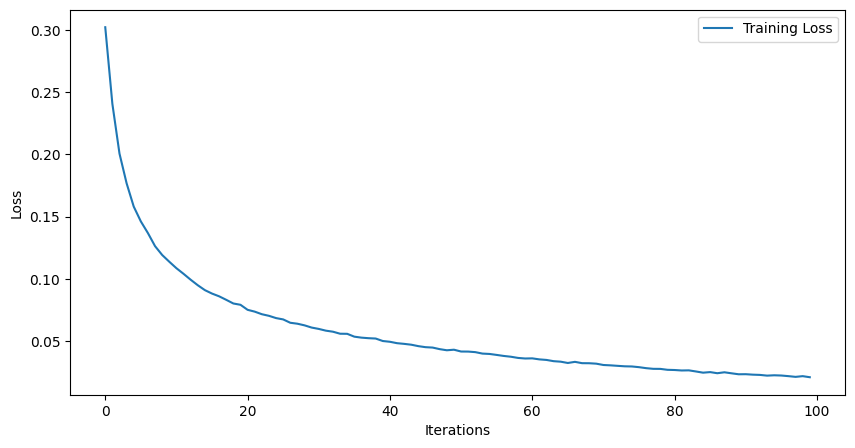

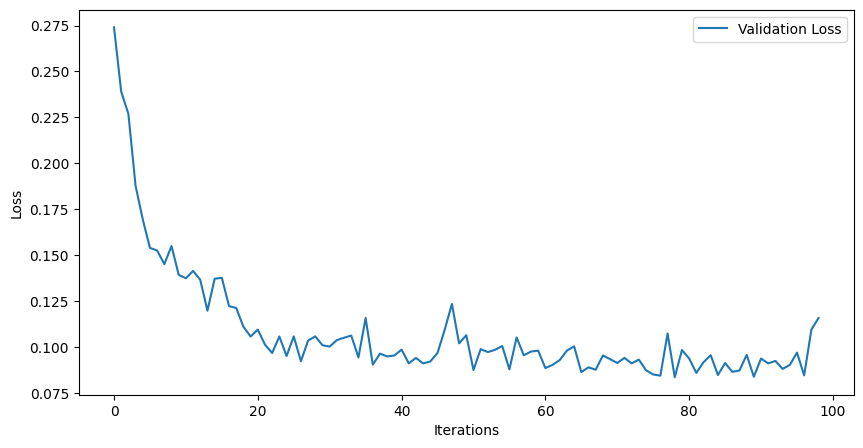

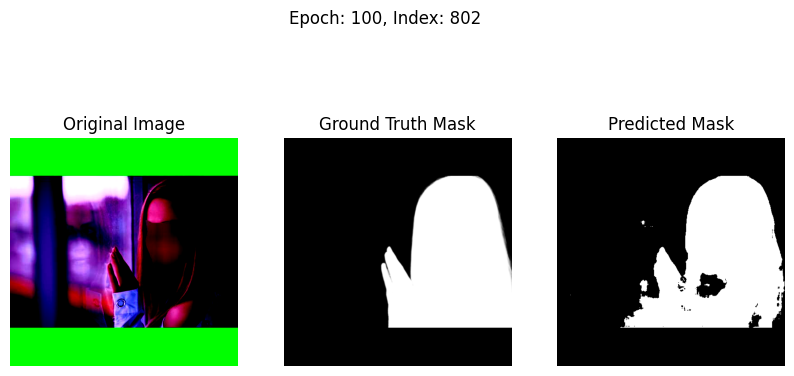

In Validation
Epoch [100], Validation Loss: 0.0917560034443072


In [16]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np

def plot_loss(loss_values, val_loss_values):
    clear_output(wait=True)

    plt.figure(figsize=(10, 5))
    plt.plot(loss_values, label='Training Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()

    plt.figure(figsize=(10, 5))
    plt.plot(val_loss_values, label='Validation Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()

def plot_masks(image, true_mask, pred_mask, epoch, idx, loss_values, val_loss_values):
    plot_loss(loss_values, val_loss_values)

    # Ensure we're only plotting the first image in the batch
    if image.dim() == 4:  # Check if the input tensor is in the format [B, C, H, W]
        image = image[0]  # Take the first image of the batch
    if true_mask.dim() == 4:
        true_mask = true_mask[0]  # Take the first mask of the batch
    if pred_mask.dim() == 4:
        pred_mask = pred_mask[0]  # Take the first predicted mask of the batch

    fig, axs = plt.subplots(1, 3, figsize=(10, 5))

    image_np = image.cpu().numpy().transpose(1, 2, 0)
    pred_mask_np = pred_mask.detach().cpu().numpy().squeeze()  # Remove singleton dimensions

    if true_mask is not None:
        true_mask_np = true_mask.cpu().numpy().squeeze()  # Remove singleton dimensions
        axs[1].imshow(true_mask_np, cmap='gray')
        axs[1].set_title('Ground Truth Mask')
        axs[1].axis('off')

    axs[0].imshow(image_np)
    axs[0].set_title('Original Image')
    axs[0].axis('off')
    
    axs[2].imshow(pred_mask_np, cmap='gray')
    axs[2].set_title('Predicted Mask')
    axs[2].axis('off')
    
    plt.suptitle(f'Epoch: {epoch}, Index: {idx}')
    plt.show()

loss_values = []
val_loss_values = []

for epoch in range(100):
    model.train()
    tra_loss = 0
    for i, sample in enumerate(train_loader):
        images, masks = sample['images'], sample['masks']
        optimizer.zero_grad()
        outputs = model(images)  

        loss = criterion(outputs, masks) 
        loss.backward()
        optimizer.step()

        #if debug:
        #    loss_values.append(loss.item())
        #else:
        #    tra_loss += loss.item()
        tra_loss += loss.item()
        
        if (i + epoch) % 500 == 0 and debug:
            pred_mask = outputs > 0.5  # Apply threshold to get binary mask
            plot_masks(images, masks, pred_mask, epoch+1, i+1, loss_values, val_loss_values)
            print(f'Epoch [{epoch+1}], Loss: {loss.item()}')


    tra_loss /= len(train_loader)
    loss_values.append(tra_loss)
    plot_loss(loss_values, val_loss_values)
    print(f'Epoch [{epoch+1}], Loss: {tra_loss}')
 
    torch.save(model.state_dict(), f'backups/epoch{epoch}.pth')



    # Validation step
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No need to track gradients for validation
        val_loss = 0
        for i, sample in enumerate(validation_loader):
            images, masks = sample['images'], sample['masks']
            outputs = model(images)  

            loss = criterion(outputs, masks)
            val_loss += loss.item()

            if (i + epoch) % 100 == 0 and debug:
                pred_mask = outputs > 0.5  # Apply threshold to get binary mask
                plot_masks(images, masks, pred_mask, epoch+1, i+1, loss_values, val_loss_values)
                print('In Validation')

        val_loss /= len(validation_loader)
        val_loss_values.append(val_loss)
        print(f'Epoch [{epoch+1}], Validation Loss: {val_loss}')

In [17]:
# save the model
torch.save(model.state_dict(), 'cnn.pth')
